<a href="https://colab.research.google.com/github/nyp-sit/it3103/blob/main/week4/using_pretrained_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/nyp-sit/sdaai-iti107/blob/main/session-2/using_pretrained_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab" align="left"/></a>

# Using Pretrained CNN models

Welcome to this week's programming exercise. We have covered many different Convolutional Neural Network architectures such as VGG, ResNet, Inception and MobileNet. It is time to see them in action. 

At the end of this exercise, you will be able to: 
- load pretrained models of some popular Convolutional Neural Networks and use them to classify images
- identify some of the architecture patterns in the popular Convolutional Neural Network
- compare the inference speed of different models


## Prepare image data

If you want to test it with your own picture, download them to your local PC (or the server, if you are using the class VM) and change the img_path to point to your download picture.


In [1]:
# Change the following to your own image
img_path = 'data/chair_table.jpg'

In [2]:
from PIL import Image
from tensorflow.keras.preprocessing import image
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

%matplotlib inline

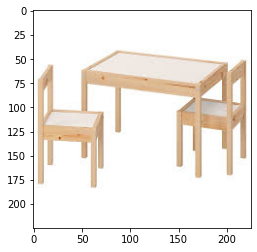

In [3]:
import matplotlib.image as mpimg 
import matplotlib.pyplot as plt 
  
# Read Images 
img = mpimg.imread(img_path) 
  
# Output Images 
plt.imshow(img) 

## VGG16 - Pretrained Model

In [4]:
from tensorflow.keras.applications import vgg16

vgg16_model = vgg16.VGG16(weights='imagenet')
vgg16_model.summary()

553467904/553467096 [==============================] - 5s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

***Questions***

1. What is the expected input image size?
2. What are the last four layers in VGG-16? 

<details><summary>Click here for answer</summary>
    
1. it is expected to have a height of 224 and width of 224
2. the last 4 layers are flatten (which flattens the 2-D array into 1-D array before feeding to FC layer), and 2 Fully-connected (Dense) layers, and the last layer is a soft-max layer to classify 1000-classes. This is quite typical of a image classifier.

</details>

In [5]:
# Utility Function to Load Image, Preprocess input and Targets
def predict_image(model, img_path, preprocess_input_fn, decode_predictions_fn, target_size=(224,224)):
    img = image.load_img(img_path, target_size=target_size)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input_fn(x)
    preds = model.predict(x)
    predictions_df = pd.DataFrame(decode_predictions_fn(preds, top=10)[0])
    predictions_df.columns = ["Predicted Class", "Name", "Probability"]
    return predictions_df

In [6]:
#img_path="rocking_chair.png"  ## Uncomment this and put the path to your file here if desired
# Predict Results
predict_image(vgg16_model, img_path, vgg16.preprocess_input, vgg16.decode_predictions)

40960/35363 [==================================] - 0s 0us/step


,Predicted Class,Name,Probability
0,n03201208,dining_table,0.455081
1,n03179701,desk,0.136859
2,n03721384,marimba,0.120221
3,n03017168,chime,0.085920
4,n03376595,folding_chair,0.020362
5,n04344873,studio_couch,0.015991
6,n03447721,gong,0.011673
7,n03888605,parallel_bars,0.011272
8,n03131574,crib,0.010956
9,n03961711,plate_rack,0.009779


Notice that we pass in `vgg.preprocess_input` function to preprocess the image before calling `model.predict()`. Different network (e.g. VGG, ResNet, etc) expects the input image to be normalized in different ways, and different models will provide their own preprocess_input() function to perform the normalization.

We also call `np.expand_dims(x, axis=0)` before calling `preprocess_input()` and `predict()`. 

***Question***

1. What does `np.expand_dims(x, axis=0)` do and why do we need it? 
2. Our sample picture consists of both table and chair? What does VGG16 predict? and why do you think it predicts so?


<details><summary>Click here for answer</summary>

1. np.expand_dims() increases the number of dimensions and the axis of the new dimension is specified by the axis parameter. In this case, we add in a new axis as axis=0, first axis. This is because the preprocess_input() and predict() function expects the images to be in the shape (samples, height, width, channels), the 1st axis being the batch.

2. It predicts dining table. It probably focus on the object in the middle of the image.

</details>

## Resnet50 - Pretrained Model

In [7]:
# It will download the weights that might take a while
# Also, the summary will be quite long, since Resnet50 is a much larger network than VGG16

from tensorflow.keras.applications import resnet50

resnet50_model = resnet50.ResNet50(weights='imagenet')

resnet50_model.summary()

102973440/102967424 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
________________________

***Questions***

1. Can you identify the skip connection block from the model summary()?
2. Look at the last few layers in the ResNet. How are they different from those of VGG-16?

<details><summary>Click here for answer</summary>
    
1. Look for those 'Add' layer (e.g. layer with name add_2). The Add layer adds the skip connection with the previous layer. Notice that the add is done before the Activation function. You can also call plot_model() to get a graphical visualization of the model.

2. ResNet does not use make use of Full-connected layers as classification layers. Instead it replaces the FC layers with GlobalAveragePooling2D. This architecture is very common in more modern architectures.

</details>

In [8]:
## Uncomment the following to visualize the model in graphical form
#from tensorflow.keras.utils import plot_model
#plot_model(resnet50_model)

In [9]:
# Predict Results
predict_image(resnet50_model, img_path, resnet50.preprocess_input, resnet50.decode_predictions)

,Predicted Class,Name,Probability
0,n03201208,dining_table,0.792640
1,n03376595,folding_chair,0.109668
2,n02788148,bannister,0.037102
3,n03065424,coil,0.007126
4,n03721384,marimba,0.006281
5,n03729826,matchstick,0.003988
6,n03888605,parallel_bars,0.003032
7,n03804744,nail,0.001928
8,n03961711,plate_rack,0.001816
9,n03179701,desk,0.001762


## MobileNet v1 - Pretrained Model

In [10]:
from tensorflow.keras.applications import mobilenet
mobilenet_model = mobilenet.MobileNet(weights='imagenet')
mobilenet_model.summary()

17227776/17225924 [==============================] - 0s 0us/step
Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________

***Questions***

1. Can you identify the Depth-wise separable Convolution layer from the model summary()?
2. How about the Point-wise convolution? 
3. Look at the last few layers in the MobileNet. How are they different from those of VGG-16?

<details><summary>Click here for answer</summary>

1. For example, the layer called 'conv_dw1'. 

2. For example, the layer called 'conv_pw1'. 

3. MobileNet does not use make use of Full-connected layers as classification layers. Instead it replaces the FC layers with GlobalAveragePooling2D. This architecture is very common in more modern architectures.
    
</details>

In [11]:
predict_image(mobilenet_model, img_path, mobilenet.preprocess_input, mobilenet.decode_predictions)


,Predicted Class,Name,Probability
0,n03201208,dining_table,0.808176
1,n03179701,desk,0.108741
2,n02788148,bannister,0.032575
3,n03888605,parallel_bars,0.016391
4,n03903868,pedestal,0.004526
5,n04550184,wardrobe,0.004120
6,n03992509,potter's_wheel,0.003203
7,n03467068,guillotine,0.002165
8,n03017168,chime,0.002099
9,n02777292,balance_beam,0.001487


### Speed comparison 

We compare the inference speed of the three different models. Which one has the fastest inference speed?

In [12]:
%timeit predict_image(vgg16_model, img_path, vgg16.preprocess_input, vgg16.decode_predictions)


1 loop, best of 5: 550 ms per loop


In [13]:
%timeit predict_image(resnet50_model, img_path, resnet50.preprocess_input, resnet50.decode_predictions)


1 loop, best of 5: 210 ms per loop


In [14]:
%timeit predict_image(mobilenet_model, img_path, mobilenet.preprocess_input, mobilenet.decode_predictions)

10 loops, best of 5: 85.4 ms per loop


#### Additional Exercises 

1. Experiment with other networks such as InceptionV3 and compare the accuracy and speed with VGG/ResNet/MobileNet.
2. Identify the architectual patterns used in such networks.